In [6]:
import tensorflow as tf
from keras.layers import Input, Dense, Layer, LSTM
from keras.models import Model
from keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 2D의 feature 데이터로 3D의 RNN 학습 데이터 만들기
def build_rnn_data(data, t_step, n_jump=1):
    n_data = data.shape[0] # number of data
    m = np.arange(0, n_data - t_step, n_jump)
    x = np.array([data[i:(i+t_step), :] for i in m]) # feature data
    y = np.array([data[i, :] for i in (m + t_step)]) # target data
    return x, y

In [3]:
# 시계열 데이터 (noisy sin 2개)
n = 1000
s1 = np.sin(np.pi * 0.06 * np.arange(n)) + np.random.random(n)
s2 = 0.5*np.sin(np.pi * 0.05 * np.arange(n)) + np.random.random(n)
data = np.vstack([s1,s2]).T

In [4]:
# 학습 데이터 생성
t_step = 20
x_train, y_train = build_rnn_data(data, t_step)

In [5]:
# LSTM 모델 생성하기
n_input = x_train.shape[-1]
n_output = y_train.shape[-1]
n_hidden = 50

In [7]:
x_input = Input(batch_shape=(None, t_step, n_input))
h = LSTM(n_hidden)(x_input)
y_output = Dense(n_output)(h)

model = Model(x_input, y_output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 2)]           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 10702 (41.80 KB)
Trainable params: 10702 (41.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# 학습하기
hist = model.fit(x_train, y_train, epochs=50, batch_size=50)

Epoch 1/50
20/20 [==============================] - 1s 4ms/step - loss: 0.4598
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.2505
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1486
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.1232
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1097
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1029
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0986
Epoch 9/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0970
Epoch 10/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0960
Epoch 11/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0956
Epoch 12/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0959
Epoch 13/50
20/20 [==============================

In [9]:
# 향후 50 기간 데이터를 예측한다. 향후 1 기간을 예측하고,
# 예측값을 다시 입력하여 2기간을 예측한다.
# 이런 방식으로 50기간까지 예측한다.
n_future = 50
n_last = 100
last_data = data[-n_last:] # 원본 데이터의 마지막 n_last개만 그려보기
for i in range(n_future):
    # 마지막 t_step만큼 입력 데이터로 다음 값을 예측한다.
    px = last_data[-t_step:, :].reshape(1, t_step, 2)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px,verbose=0)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기 위해 예측한 값을 지정해 둔다.
    last_data = np.vstack([last_data, y_hat])

p = last_data[:-n_future, :]     # past data
f = last_data[-(n_future+1):, :] # future data

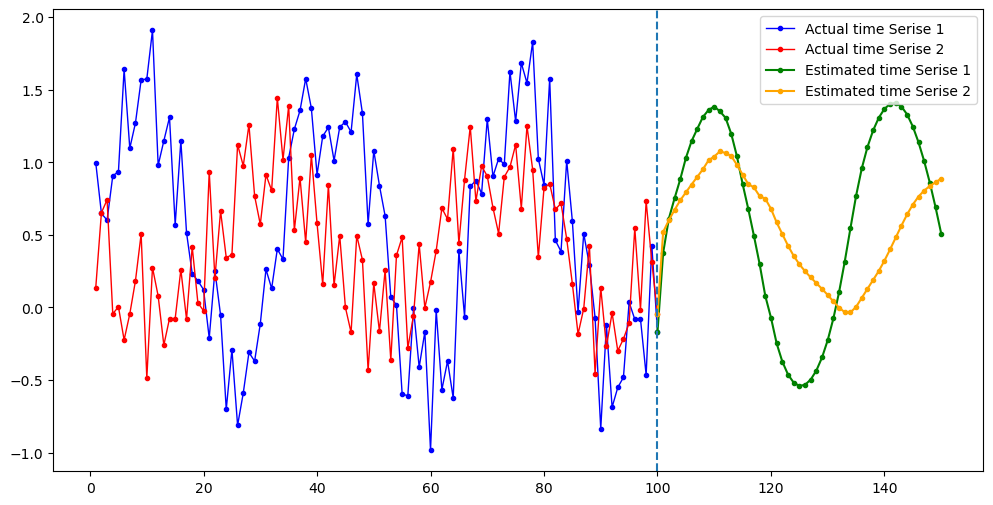

In [10]:
# 원본 시계열과 예측된 시계열을 그려본다.
plt.figure(figsize=(12,6))
ax1 = np.arange(1, len(p) + 1)
ax2 = np.arange(len(p), len(p) + len(f))
plt.plot(ax1, p[:, 0], '-o', c='blue', markersize=3, label='Actual time Serise 1', linewidth=1)
plt.plot(ax1, p[:, 1], '-o', c='red', markersize=3, label='Actual time Serise 2', linewidth=1)
plt.plot(ax2, f[:, 0], '-o', c='green', markersize=3, label='Estimated time Serise 1')
plt.plot(ax2, f[:, 1], '-o', c='orange', markersize=3, label='Estimated time Serise 2')

plt.axvline(x=ax1[-1], linestyle='dashed')
plt.legend()
plt.show()